In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sys
import json
import cv2
import numpy as np
from PIL import Image
import pycocotools.mask as maskUtils

from matting_api import Matting

sys.path.append('..')
import utils
import inference as infer
from datasets import COCOADataset, read_COCOA
from demo_utils import *

font = {'family' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

In [2]:
# None if out of bounds, otherwise return coord
def clamp_or_none(coord, R, C):
    r, c = coord
    return coord if (r >= 0 and r < R) and (c >= 0 and c < C) else None

# [UpperLeft, Top, UpperRight, Left, Right, BottomLeft, Bottom, BottomRight]
def neighbors(r, c, R, C, off=3):
    lst = [(r - off, c - off), (r - off, c), (r - off, c + off), (r, c - off), 
           (r, c + off), (r + off, c - off), (r + off, c), (r + off, c + off)]
    return [clamp_or_none(coord, R, C) for coord in lst]

In [3]:
import cv2

def pad_mask(mask, size=9):
    kernel = np.ones((size, size))
    return cv2.filter2D(mask, 1, kernel)

In [157]:
from tqdm import tqdm

channels = 8

phase = 'train'
root_dict = {'train': "../data/COCOA/train2014", 'val': "../data/COCOA/val2014"}

img_root = root_dict[phase]
annot_path = "../data/COCOA/annotations/COCO_amodal_{}2014.json".format(phase)

output_root = "../data/COCOA/pixel_graphs_{}/".format(phase)

data_reader = COCOADataset(annot_path)
img_count = len(data_reader.annot_info)

for img_idx in tqdm(range(img_count)):
    modal, category, ori_bboxes, amodal_gt, image_fn = data_reader.get_image_instances(
        img_idx, with_gt=True, ignore_stuff=True)
    
    modal_count = len(modal)
    gt_order_matrix = infer.infer_gt_order(modal, amodal_gt)
    
    image_fn = os.path.join(img_root, image_fn)
    img = Image.open(image_fn)
    height, width = img.height, img.width
    image = np.array(img)
    
    # Construct modals and graph
    modals = np.zeros((height, width))
    for i in range(modal_count):
        modals += (i + 1) * (modal[i] > 0)
    graph = np.zeros((height, width, channels))

    for r in range(height):
        for c in range(width):
            pairs = neighbors(r, c, height, width)
            for k in range(channels):
                pair = pairs[k]
                if not pair:
                    continue
                u, v = pair
                i, j = int(modals[r, c]), int(modals[u, v])
                if not i and j:
                    graph[r, c, k] = -1
                elif not j and i:
                    graph[r, c, k] = 1
                elif not j and not i:
                    graph[r, c, k] = 0
                else:
                    graph[r, c, k] = gt_order_matrix[i - 1, j - 1]
    
    # Save graph
    path = os.path.join(output_root, str(img_idx) + '_graph')
    tensor = torch.tensor(graph)
    torch.save(tensor, path)
    
    # Save mask
    mask = pad_mask(1 * (modals > 0)) > 0
    path = os.path.join(output_root, str(img_idx) + '_mask')
    tensor = torch.tensor(mask)
    torch.save(tensor, path)

100%|██████████| 2500/2500 [1:30:05<00:00,  2.16s/it]


# Reconstruction

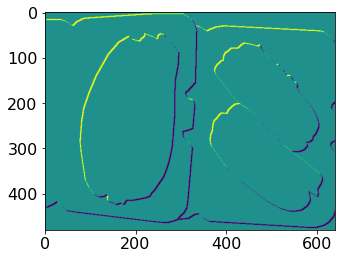

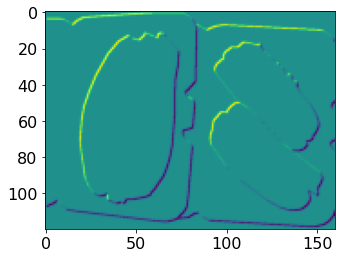

In [39]:
phase = 'train'
output_root = "../data/COCOA/pixel_graphs_{}/".format(phase)

path = os.path.join(output_root, str(0) + '_graph')
_graph = torch.load(path)

plt.imshow(_graph[:, :, 0])
plt.show()

graph = skimage.transform.resize(_graph, np.array(_graph.shape[:2]) / 4)
# graph[graph < -0.45] = -1
# graph[graph > 0.45] = 1

plt.imshow(graph[:, :, 0])
plt.show()

$$
X_a - X_b = O_{a, b} \\
\min_x \sum_a \sum_{b \in N_a} X_a - X_b - O_{a, b} \\
\equiv \min_x \left\lVert 
\begin{bmatrix}
0 & 0 & \dots & 1 & \dots & -1 & 0 \\
0 & 0 & \dots & 1 & \dots & -1 & 0 \\
& & & \vdots & & & \\
0 & 0 & \dots & 1 & \dots & -1 & 0 \\
\end{bmatrix} x - 
\begin{bmatrix}
O_{a, b} \\ O_{a, b} \\ \vdots \\ O_{a, b}
\end{bmatrix}
\right\rVert_2
$$

In [40]:
import scipy.sparse as sparse
from tqdm import tqdm
from multiprocessing import Pool
import os
import time

In [41]:
def sparse_image_vector(R, C):
    return sparse.lil_matrix(np.zeros(R * C))

# Must be row-major
def position_to_index(coord, R, C):
    r, c = coord
    return r * C + c

In [42]:
def format_lstsq(rs):
    A = []
    b = np.array([])
    
    for r in rs:
        for c in range(C):
            pairs = neighbors(r, c, R, C)     
            for k in range(K):
                pair = pairs[k]
                if not pair:
                    continue
                u, v = pair
                a = sparse_image_vector(R, C)
                i, j = position_to_index((r, c), R, C), position_to_index((u, v), R, C)
                a[0, i], a[0, j] = 1, -1
                A.append(a)
                b = np.append(b, graph[r, c, k])
    
    return A, b

In [43]:
start_time = time.time()

R, C, K = graph.shape

n_workers = os.cpu_count()
ranges = [range(int(R * i / n_workers), int(R * (i + 1) / n_workers)) for i in range(n_workers)]

print("Beginning lstsq formatting:", time.time() - start_time)

p = Pool(n_workers)
res = p.map(format_lstsq, ranges)

print("Joining A, b:", time.time() - start_time)

A = sparse.vstack(sum([As for As, b in res], []))
b = np.hstack([b for As, b in res])

print("Duration:", time.time() - start_time)

Beginning lstsq formatting: 0.00015401840209960938
Joining A, b: 10.338916301727295
Duration: 30.240774154663086


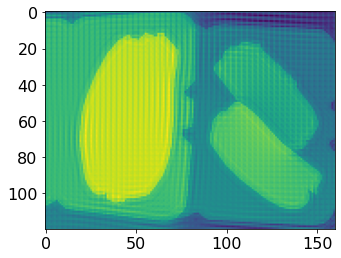

In [44]:
x = sparse.linalg.lsqr(A, b)
X = x[0].reshape((R, C))
plt.imshow(X)
plt.show()

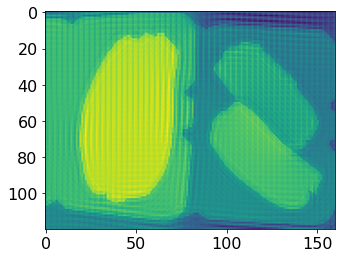

In [38]:
x = sparse.linalg.lsqr(A, b)
X = x[0].reshape((R, C))
plt.imshow(X)
plt.show()